#**Heart Failure Prediction Using Logistic Regression**


---



The aim of this project is to train a logistic regression model to identify heart disease based on various patient metrics. We will use the [Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction) to train our model.



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay,confusion_matrix, classification_report, ConfusionMatrixDisplay

Let's begin by importing our dataset and inspecting the features.

In [ ]:
df = pd.read_csv("../heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Attribute Information from the Kaggle Dataset Link:


1.   Age: age of the patient [years]
2.   Sex: sex of the patient [M: Male, F: Female]
3.   ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4.   RestingBP: resting blood pressure [mm Hg]
5.   Cholesterol: serum cholesterol [mm/dl]
6.   FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7.   RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8.   MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9.   ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10.  Oldpeak: oldpeak = ST [Numeric value measured in depression]
11.  ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12.  HeartDisease: output class [1: heart disease, 0: Normal]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [ ]:
# Checking for duplicated rows
len(df[df.duplicated()])

0

In [ ]:
# Checking for null entries
df.isnull().sum()

,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


In [ ]:
# Generating a statistcal summary of numeric columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [ ]:
# How many rows have cholesterol=0?
len(df[df['Cholesterol']==0])

172

I'm noticing something strange about the Cholesterol values. There are 172 instances of Cholesterol = 0. I'm not sure what's going on here, but there are a couple approaches I can take here. First, I'll try replacing these 0 values with the median value (mean is too sensitive to outliers, so I think median is a better choice here). If the model doesn't perform well, I'll try removing the 0 value entries.

In [ ]:
df['Cholesterol'].median()

223.0

In [ ]:
# Using Pandas' apply method to replace Cholesterol 0-values with the median 223
df['Cholesterol'] = df['Cholesterol'].apply(lambda x: 223.0 if x==0 else x)

In [ ]:
# Confirming the replacement command above worked as intended
len(df[df['Cholesterol']==0])

0

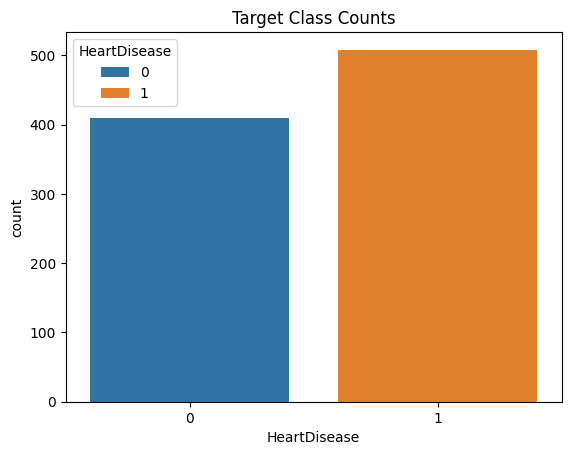

In [ ]:
# Inspecting our dataset's class balance
sns.countplot(data=df, x='HeartDisease',hue='HeartDisease')
plt.title('Target Class Counts')
plt.show()

Not a terribly imbalanced dataset.

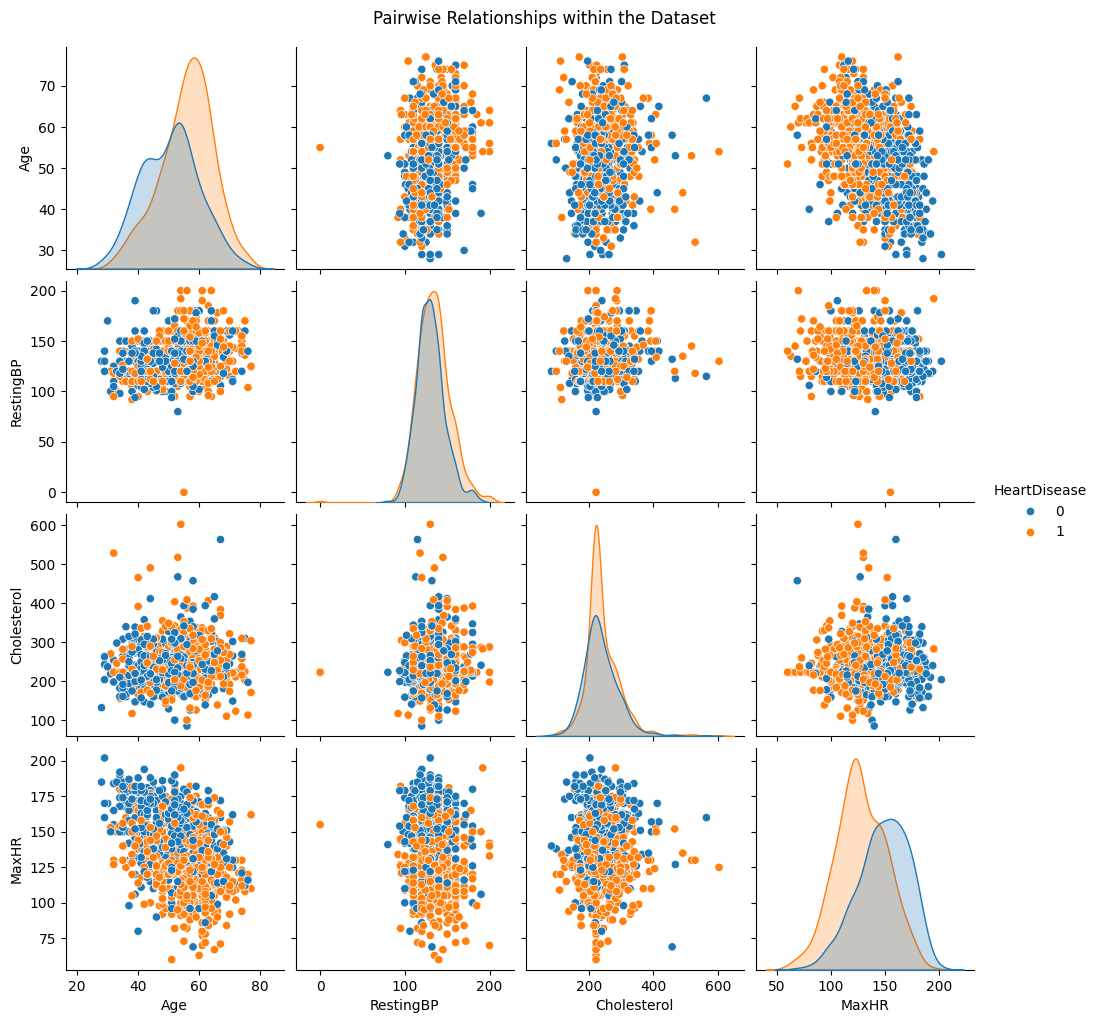

In [ ]:
# Creating a visualization of pairwise relationships between numerical features
g = sns.pairplot(data=df[['Age','RestingBP','Cholesterol','MaxHR','HeartDisease']],hue='HeartDisease')
g.fig.suptitle("Pairwise Relationships within the Dataset", y=1.02)
plt.show()

The figure above provides us some insight regarding which features might be helpful in predicting heart failure. To begin, inspection of the grid's diagonal reveals distinct peaks between target (heart disease) values in the distributions of age and max heart rate. This might suggest that these features are of high value when classifying heart disease. It certainly makes intutive sense that older populations and individuls with lower maximum heart rates are at higher risk for heart disease.

Additionally, we have a clue that our cholesterol value replacement approach may not have been helpful. The cholesterol kernel density estimation plot is centered around a value slightly above 200 mm/dl (close to the median value 223 mm/dl). Domain knowledge indicates that cholesterol values are important indicators of heart disease risk, and I would expect to see distinct peaks between target values when examining the kde plot for this feature. In any case, we will circle back to the alternative approach of dropping 0 value cholesterol entries after evaluating our model.

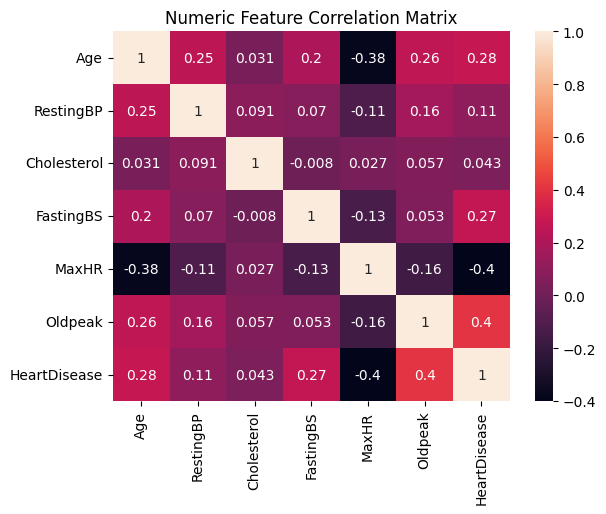

In [ ]:
# Generating visualization of correlation coefficients between numeric variables
sns.heatmap(df.corr(numeric_only=True),annot=True)
plt.title('Numeric Feature Correlation Matrix')
plt.show()

The heatmap above reveals moderate correlations between many our dataset's features and heart disease. I take this as a promising sign moving forward with our model.

We have a few categorical features. The approach we'll take is as follows:

1. Split the data into numerical / categorical dataframes.

2. Create dummy variables in the categorical dataframe (removing the first level to reduce multicollinearity).

3. Concatenate the two dataframes.


In [ ]:
# Separating numerical and categorical columns
df_objs = df.select_dtypes(include='object')
df_nums = df.select_dtypes(exclude='object')

In [ ]:
# Creating dummy variables for categorical data
df_objs = pd.get_dummies(df_objs.astype(str),drop_first=True,dtype=int)
df_objs

,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,1,1,0,0,1,0,0,0,1
1,0,0,1,0,1,0,0,1,0
2,1,1,0,0,0,1,0,0,1
3,0,0,0,0,1,0,1,1,0
4,1,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
913,1,0,0,1,1,0,0,1,0
914,1,0,0,0,1,0,0,1,0
915,1,0,0,0,1,0,1,1,0
916,0,1,0,0,0,0,0,1,0


In [ ]:
# Combining the dataframes
final_df = pd.concat([df_nums,df_objs],axis=1)

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                918 non-null    int64  
 1   RestingBP          918 non-null    int64  
 2   Cholesterol        918 non-null    float64
 3   FastingBS          918 non-null    int64  
 4   MaxHR              918 non-null    int64  
 5   Oldpeak            918 non-null    float64
 6   HeartDisease       918 non-null    int64  
 7   Sex_M              918 non-null    int64  
 8   ChestPainType_ATA  918 non-null    int64  
 9   ChestPainType_NAP  918 non-null    int64  
 10  ChestPainType_TA   918 non-null    int64  
 11  RestingECG_Normal  918 non-null    int64  
 12  RestingECG_ST      918 non-null    int64  
 13  ExerciseAngina_Y   918 non-null    int64  
 14  ST_Slope_Flat      918 non-null    int64  
 15  ST_Slope_Up        918 non-null    int64  
dtypes: float64(2), int64(14)
m

##Preparing the data for our model:
1. Split the data into train/test sets.
2. Fit a StandardScaler object to the training data.
3. Normalize the X_train and X_test data. This standardizes features by removing the mean and scaling to unit variance.

In [ ]:
X = final_df.drop('HeartDisease',axis=1)
y = final_df['HeartDisease']

In [ ]:
# Splitting our data for model training and evaluation. Reserving 20% of the data for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [ ]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train) #this fits the scaler to X_train and normalizes the data in one step
scaled_X_test = scaler.transform(X_test)

## Training our Logistic Regression Model
We will use sklearn's LogisticRegressionCV classifier. This performs cross validation to optimize hyperparameter C for regularization strength.

In [ ]:
log_model = LogisticRegressionCV(max_iter=1000000,verbose=1,cv=20)
log_model.fit(scaled_X_train,y_train)

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


LogisticRegressionCV(cv=20, max_iter=1000000, verbose=1)

In [ ]:
log_model.C_

array([2.7825594])

In [ ]:
log_model.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': 20,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 1000000,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 1}

In [ ]:
log_model.coef_

array([[ 0.1647277 , -0.00122596, -0.04970897,  0.58129557, -0.24536827,
         0.29130826,  0.67290631, -0.71417821, -0.60251416, -0.23582901,
        -0.05326176, -0.0212183 ,  0.49593328,  0.62051891, -0.65655669]])

In [ ]:
# Inspecting model coefficient values
coefs = log_model.coef_[0]
df_coef = pd.Series(data=coefs,index=X.columns).sort_values()
df_coef

,0
ChestPainType_ATA,-0.714178
ST_Slope_Up,-0.656557
ChestPainType_NAP,-0.602514
MaxHR,-0.245368
ChestPainType_TA,-0.235829
RestingECG_Normal,-0.053262
Cholesterol,-0.049709
RestingECG_ST,-0.021218
RestingBP,-0.001226
Age,0.164728


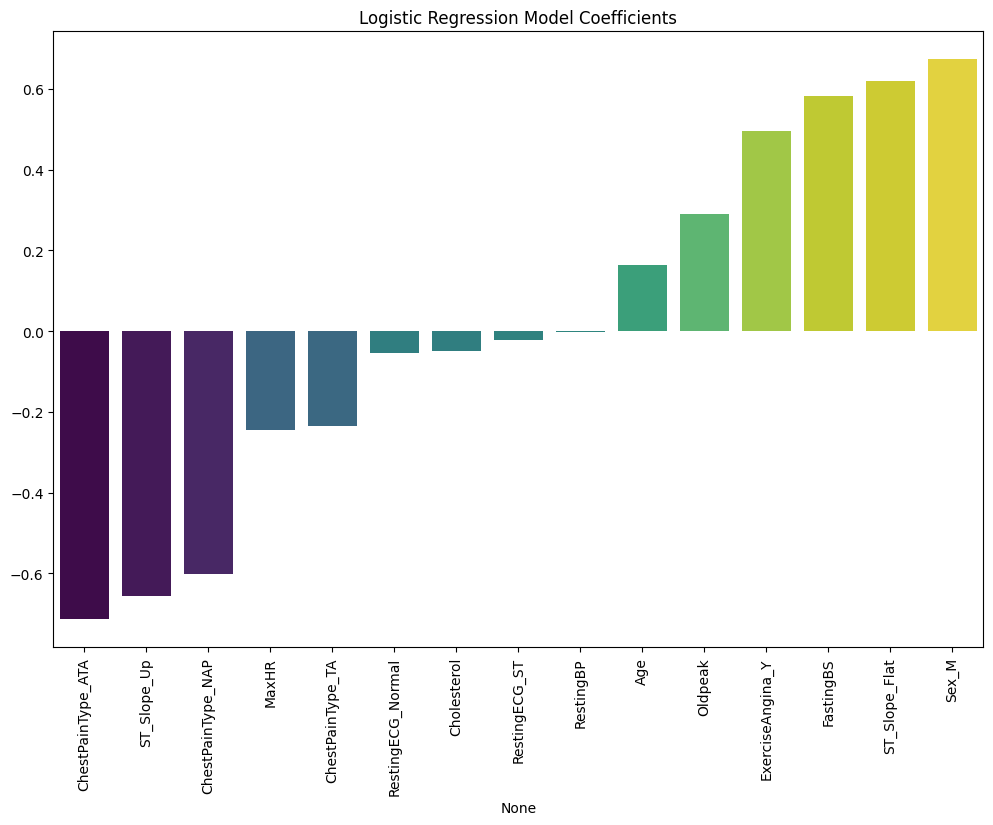

In [ ]:
# Generating a visualization of model coefficient values
plt.figure(figsize=(12,8))
sns.barplot(x=df_coef.index,y=df_coef.values,hue=df_coef.values,legend=False,palette='viridis')
plt.xticks(rotation=90)
plt.title('Logistic Regression Model Coefficients')
plt.show()

## Model Performance Evaluation

In [ ]:
y_pred = log_model.predict(scaled_X_test)

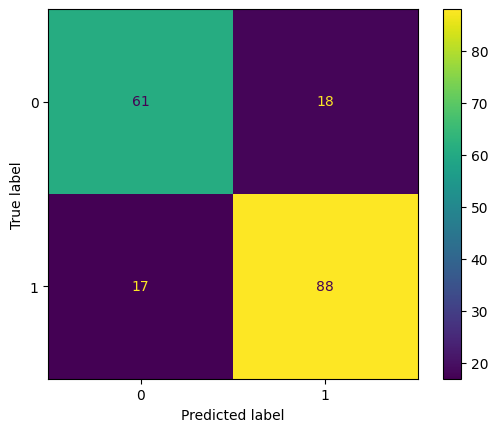

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.77      0.78        79
           1       0.83      0.84      0.83       105

    accuracy                           0.81       184
   macro avg       0.81      0.81      0.81       184
weighted avg       0.81      0.81      0.81       184



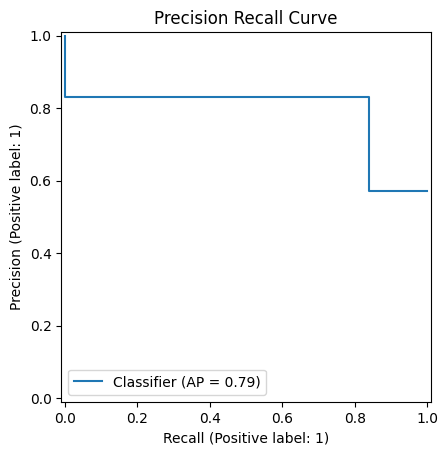

In [ ]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred)
plt.title('Precision Recall Curve')
plt.show()

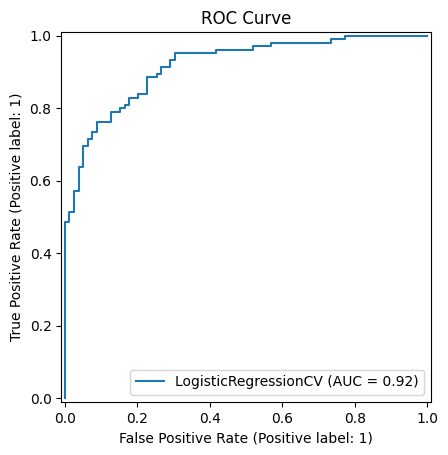

In [ ]:
RocCurveDisplay.from_estimator(log_model, scaled_X_test, y_test)
plt.title('ROC Curve')
plt.show()

## Interpretation of Model Results


Precision:


For class 0 (no heart disease / normal), our model has a precision score of 78%. This means that 78% of cases predicted as normal are actually normal and 22% of cases are false negatives.


For class 1 (patient has heart disease), our model's precision score is 83%. This means that of all the instances the model predicted as heart disease, 83% of cases actually had heart disease and 17% of cases are false positives.


Recall:


For class 0, 77% of truly normal cases were identified, and 23% of cases are false positives.


For class 1, 84% of true heart disease cases were identified, and 16% of cases are falsely classified as negative.


----------




Let's discuss the implications of this model's predictions as well as the precision-recall trade-off. High precision means that when the model predicts a patient has heart disease, it's likely correct. High recall means that the model is good at catching most of the heart disease cases, minimizing false negatives. By my estimation, high recall seems most desirable in this medical context, i.e. we want to minimize the number of false negatives (where the model incorrectly classifies a heart disease case as normal). There are costs associated with incorrectly classifying a healthy individual as having heart disease, such as unnecessary testing or treatment. A greater cost in this context, however, is when a patient with heart disease is misclassified by the model and doesn't receive necessary treatment. Therefore, I believe this model should prioritize class 1 recall, and in turn the minimization of false negatives.




There is a trade-off between precision and recall in all classification problems. Imagine we have a model that classifies every case as belonging to class 1 (Heart Disease in this dataset). This model would clearly have high recall! We may catch more true positives, but this comes at the cost of making more false positives, which decreases precision. On the other hand, increased precision is achieved when the model becomes more conservative about predicting positives. That is, the model is more likely to predict heart disease only when it's very sure. This high precision model reduces the number of false positives, but this comes at the cost of reducing recall.


Domain knowledge is necessary to determine which model evaluation measure matters the most. For example, a well performing email spam filter should have high precision and only flag true spam messages as spam. It would be terribly inconvenient if important non-spam messages were sent to the spam folder. When working with imbalanced datasets, it may be important to examine the harmonic mean of precision and recall (F1 Score), since it balances the two into a single metric. There are more evaluation measures to consider than those I listed here, but hopefully the value of careful selection is clear.


Logistic Regression models, like the one we use here, take linear combinations of feature values as input for the logistic function. This function outputs values between 0 and 1, generating probabilities of class assignment. Specifically, the relation between the logistic function's output and a threshold value determines the model's predicted output. This model uses a threshold value of 0.5, meaning a model output greater than 0.5 is a class 1 prediction. By varying this threshold value, we influence the model's predictions and therefore recall and sensitivity scores. The Precision Recall Curve above shows how precision and recall scores are influenced by changing the model's threshold, but the threshold values are not visible above. The Precision Recall Curve below includes annotations for these threshold values.


In a similar vein, we plot the ROC Curve above to see how varying the threshold value impacts True Positive Rate and False Positive rate. This plot includes the calculated Area Under the Curve (AUC), another model evaluation metric. A model with AUC = 1 perfectly classifies the data, and a model with AUC = 0.5 performs no better than random guessing.

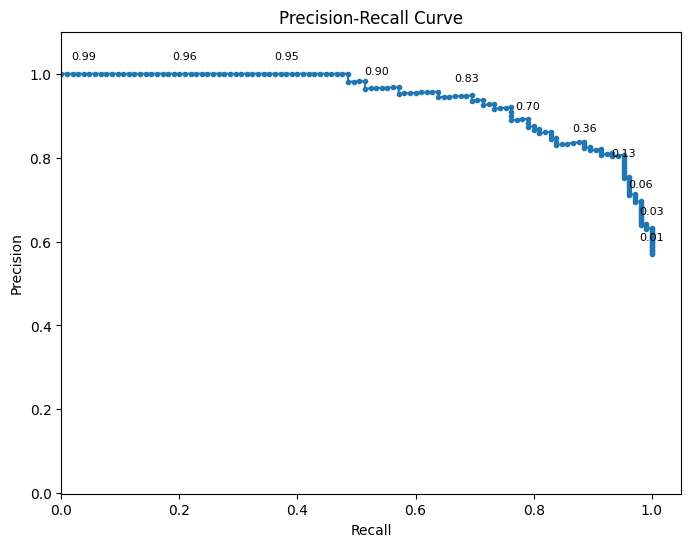

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:,1])

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Annotate specific points with threshold values
for i in range(0, len(thresholds), int(len(thresholds) / 10)):  # Annotate 10 points
    plt.annotate(f'{thresholds[i]:.2f}',
                 (recall[i], precision[i]),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center', fontsize=8)

plt.ylim((-0.001,1.1))
plt.xlim((0,1.05))
plt.show()

In [ ]:
# This cell is mostly a sanity check to confirm that our model uses a threshold of 50% when determining class prediction.
y_scores = log_model.predict_proba(scaled_X_test)

scores = {'probability class 0':y_scores[:,0],
          'probability class 1':y_scores[:,1],
          'True labels':y_test,
          'predicted labels':y_pred}

df_scores = pd.DataFrame(scores)
df_scores[(df_scores['probability class 0'] > 0.4) & (df_scores['probability class 0'] < 0.6)] # Conditional filtering instances near the threshold

,probability class 0,probability class 1,True labels,predicted labels
435,0.412339,0.587661,0,1
858,0.582782,0.417218,1,0
135,0.587793,0.412207,1,0
482,0.426918,0.573082,1,1
604,0.498575,0.501425,0,1
894,0.443012,0.556988,0,1
626,0.412733,0.587267,0,1
354,0.599497,0.400503,1,0


It is interesting to see that our model incorrectly classifies nearly every case where the predicted probabilities lie within 10% of the threshold. This makes sense intuitively, since probabilities further from the threshold suggest higher confidence.

## Circling back to a mistake from earlier...

Remember how we replaced cholesterol values of 0 with the median 223? Let's now remove the rows where cholesterol was 0, retrain our model, and compare performance.


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/python_for_ml/Portfolio_Projects/Logistic_Regression/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
drop_index = df[df['Cholesterol'] == 0].index
df.drop(drop_index, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 746 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             746 non-null    int64  
 1   Sex             746 non-null    object 
 2   ChestPainType   746 non-null    object 
 3   RestingBP       746 non-null    int64  
 4   Cholesterol     746 non-null    int64  
 5   FastingBS       746 non-null    int64  
 6   RestingECG      746 non-null    object 
 7   MaxHR           746 non-null    int64  
 8   ExerciseAngina  746 non-null    object 
 9   Oldpeak         746 non-null    float64
 10  ST_Slope        746 non-null    object 
 11  HeartDisease    746 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 75.8+ KB


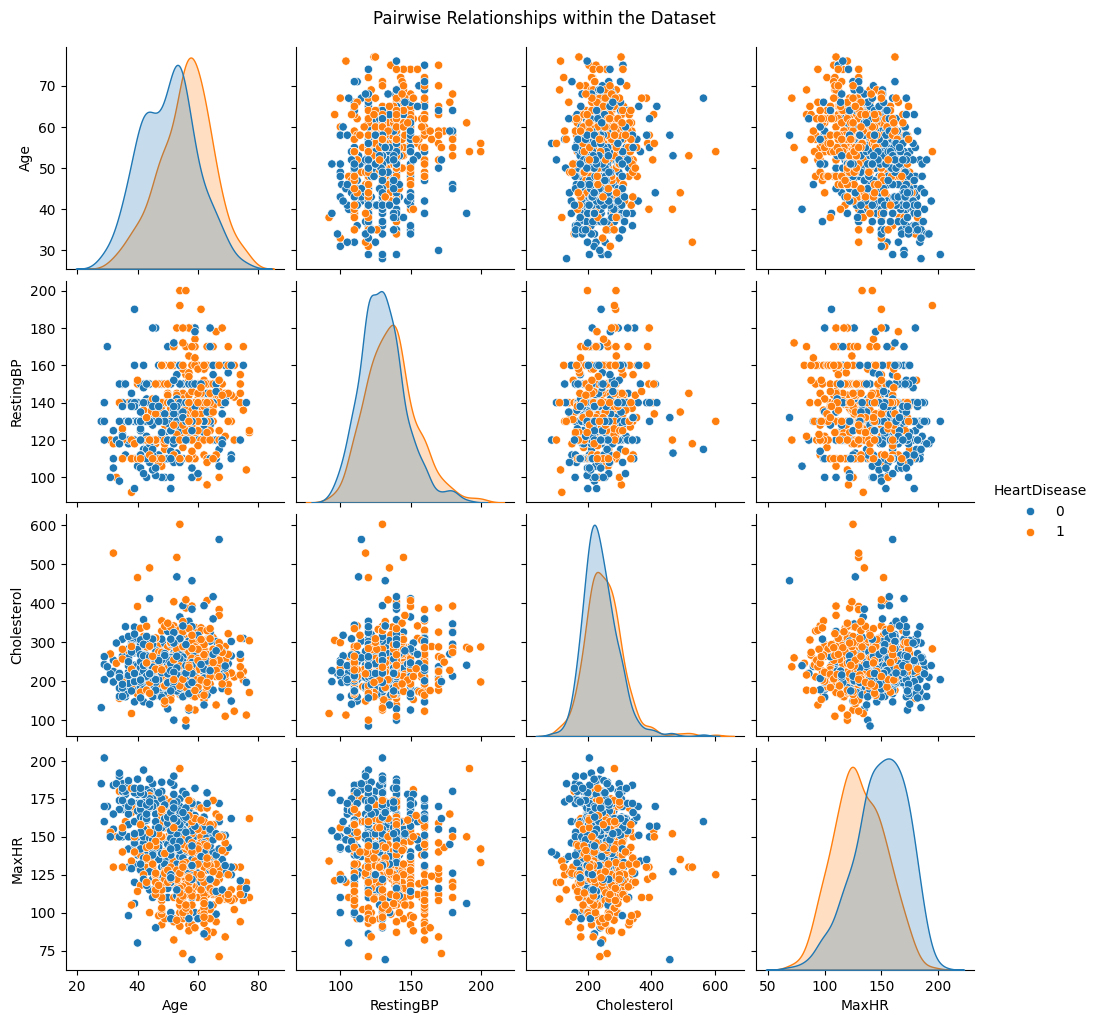

In [ ]:
# Creating a visualization of pairwise relationships between numerical features
g = sns.pairplot(data=df[['Age','RestingBP','Cholesterol','MaxHR','HeartDisease']],hue='HeartDisease')
g.fig.suptitle("Pairwise Relationships within the Dataset", y=1.02)
plt.show()

We see more distinct class peaks in cholesterol KDE plots compared to our first go. I think this is a good sign!

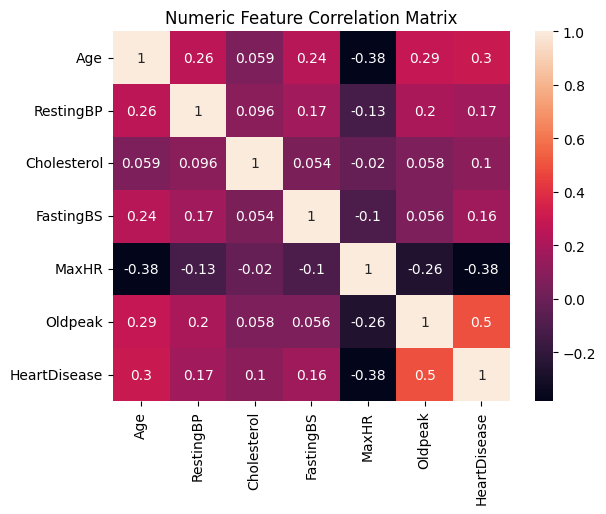

In [ ]:
# Generating visualization of correlation coefficients between numeric variables
sns.heatmap(df.corr(numeric_only=True),annot=True)
plt.title('Numeric Feature Correlation Matrix')
plt.show()

The first correlation matrix showed a correlation value of 0.043 between heart disease and cholesterol. By dropping the 0-valued cholesterol entries, we now see a correlation value of 0.1.

In [ ]:
# Separating numerical and categorical columns
df_objs = df.select_dtypes(include='object')
df_nums = df.select_dtypes(exclude='object')

# Creating dummy variables for categorical data
df_objs = pd.get_dummies(df_objs.astype(str),drop_first=True,dtype=int)
df_objs

# Combining the dataframes
final_df = pd.concat([df_nums,df_objs],axis=1)

In [ ]:
X = final_df.drop('HeartDisease',axis=1)
y = final_df['HeartDisease']

In [ ]:
# Splitting our data for model training and evaluation. Reserving 20% of the data for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train) #this fits the scaler to X_train and normalizes the data in one step
scaled_X_test = scaler.transform(X_test)

In [ ]:
log_model = LogisticRegressionCV(max_iter=1000000,verbose=1,cv=20)
log_model.fit(scaled_X_train,y_train)

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.8s finished


LogisticRegressionCV(cv=20, max_iter=1000000, verbose=1)

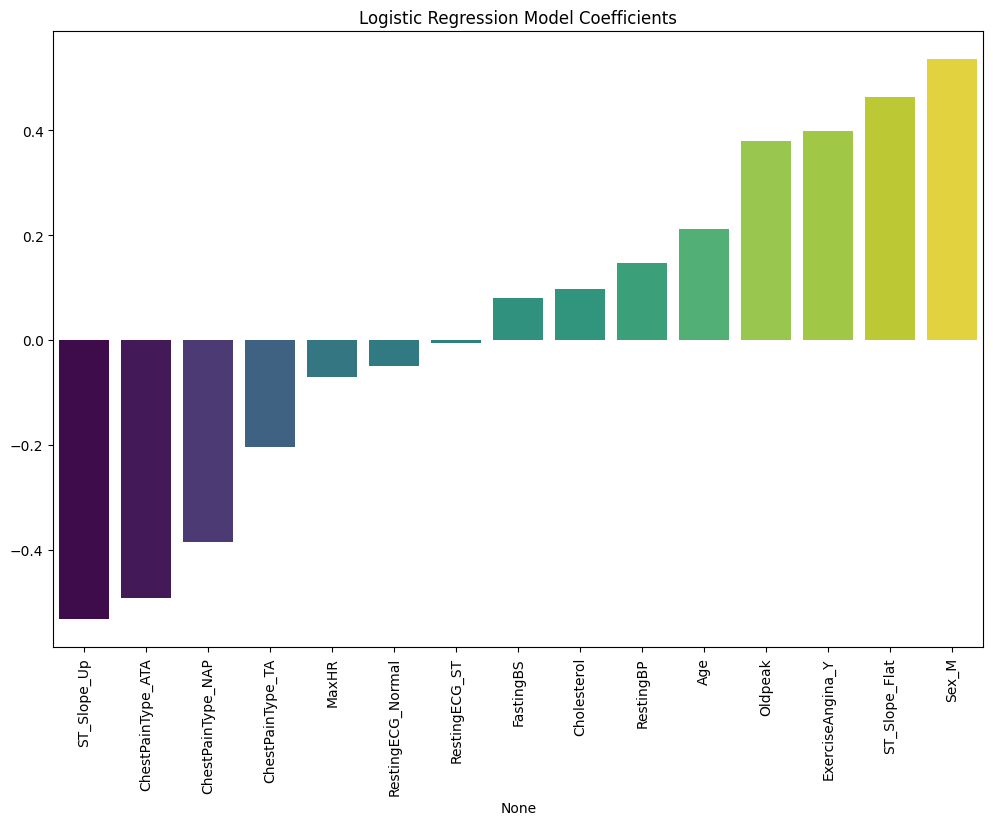

In [ ]:
# Inspecting model coefficient values
coefs = log_model.coef_[0]
df_coef = pd.Series(data=coefs,index=X.columns).sort_values()

# Generating a visualization of model coefficient values
plt.figure(figsize=(12,8))
sns.barplot(x=df_coef.index,y=df_coef.values,hue=df_coef.values,legend=False,palette='viridis')
plt.xticks(rotation=90)
plt.title('Logistic Regression Model Coefficients')
plt.show()

This model's absolute coefficient value for cholesterol is greater than that from the first model.

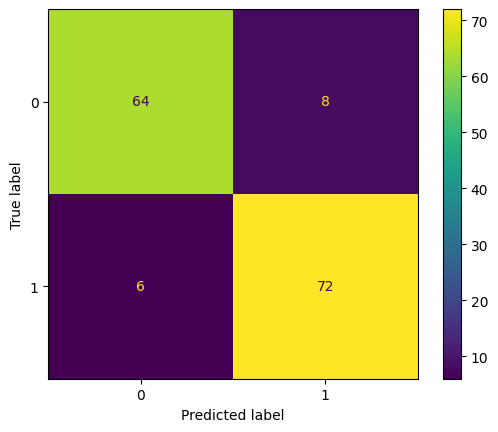

In [ ]:
y_pred = log_model.predict(scaled_X_test)

ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90        72
           1       0.90      0.92      0.91        78

    accuracy                           0.91       150
   macro avg       0.91      0.91      0.91       150
weighted avg       0.91      0.91      0.91       150



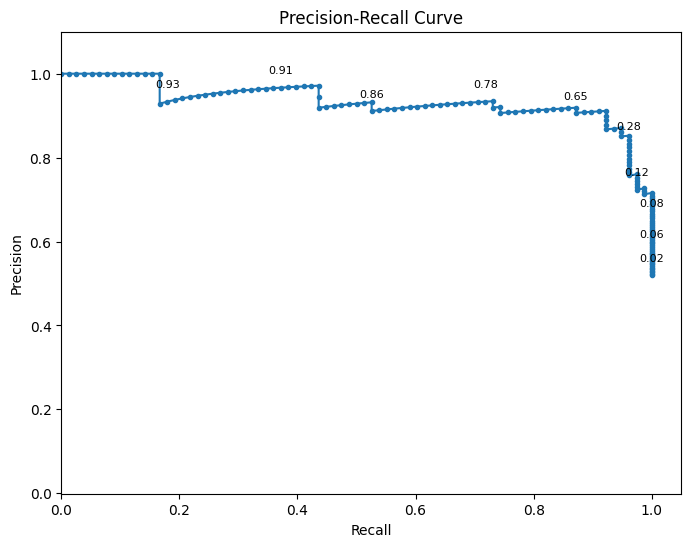

In [ ]:
y_scores = log_model.predict_proba(scaled_X_test)

precision, recall, thresholds = precision_recall_curve(y_test, y_scores[:,1])

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Annotate specific points with threshold values
for i in range(0, len(thresholds), int(len(thresholds) / 10)):  # Annotate 10 points
    plt.annotate(f'{thresholds[i]:.2f}',
                 (recall[i], precision[i]),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center', fontsize=8)

plt.ylim((-0.001,1.1))
plt.xlim((0,1.05))
plt.show()

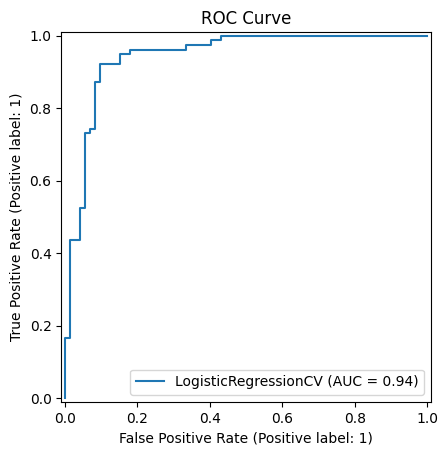

In [ ]:
RocCurveDisplay.from_estimator(log_model, scaled_X_test, y_test)
plt.title('ROC Curve')
plt.show()

## Comparing models
Class 1 Recall: 84% vs 92%

Class 1 F1 score: 83% vs 91%

Retraining our model with 0-valued cholesterol entries removed improved model performance across the board. I'm glad we circled back and repeated the experiment!

## Bonus Comparisons

Just for fun, let's compare these results to some other machine learning models. We'll take a look at K Nearest Neighbors as well as a few Decision Tree classifiers.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

We will perform cross-validation to optimize hyperparameters for each of these models. Although we decided to prioritize class 1 recall when evaluating our earlier models, we still care about precision. Let's experiment with a custom F-beta score that weighs recall more than precision, but still includes precision in the score.

In [ ]:
# Defining a custom scorer prioritizing recall
fbeta_scorer = make_scorer(fbeta_score, beta=2, average='binary')  # binary for class 1 focus

In [ ]:
# Setting up a grid search to test k-values and report best results
knn = KNeighborsClassifier()
k_values = list(range(1,30))
knn_param_grid = {
    'n_neighbors': k_values,
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],
    'p': [1, 2]  # Manhattan and Euclidean distances
}
knn_cv_classifier = GridSearchCV(estimator=knn,param_grid=knn_param_grid,cv=5,scoring=fbeta_scorer)

In [ ]:
# Setting up a grid search for the decision tree classifier
dct = DecisionTreeClassifier()
dct_param_grid = {'max_leaf_nodes':[None,3,5],
          'criterion':['gini', 'entropy'],
          'min_samples_split': [2, 5, 10],
          'max_depth':[2,3,6,8,10,None]}
dct_cv_classifier = GridSearchCV(dct,dct_param_grid,cv=5,scoring=fbeta_scorer)

In [ ]:
# Setting up a grid search for the Random Forest classifier
rfc = RandomForestClassifier(n_estimators=100)
rfc_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],  # How many features to consider when looking for best split
    'bootstrap': [True, False]         # Use bootstrap samples or not
}
rfc_cv_classifier = GridSearchCV(rfc,rfc_param_grid,cv=5,scoring=fbeta_scorer)

In [ ]:
# Setting up a grid search for the AdaBoostClassifier
adaboost = AdaBoostClassifier()
adaboost_param_grid = {
    'n_estimators': [50, 100, 200],           # Number of weak learners
    'learning_rate': [0.01, 0.1, 1.0]         # Controls contribution of each learner
}
adaboost_cv_classifier = GridSearchCV(adaboost,adaboost_param_grid,cv=5,scoring=fbeta_scorer)

In [ ]:
# Setting up a grid search for the GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb_param_grid = {
    'n_estimators': [100, 200, 300],         # Number of boosting stages
    'learning_rate': [0.01, 0.1],            # Adjusts the contribution of each tree
    'max_depth': [3, 5],                     # Controls depth of individual trees
    'min_samples_split': [2, 5],             # Minimum samples to split a node
    'min_samples_leaf': [1, 2],              # Minimum samples at a leaf node
    'subsample': [0.8, 1.0],                 # Fraction of samples to use (0.8 results in stochastic boosting)
    'max_features': ['sqrt', 'log2']         # The number of features to consider when looking for the best split
}
gb_cv_classifier = GridSearchCV(gb,gb_param_grid,cv=5,scoring=fbeta_scorer)

Next we'll fit each model, collect model predictions, plot confusion matrices, and create a dataframe with performance results.

In [ ]:
classifiers = [log_model,knn_cv_classifier,dct_cv_classifier,rfc_cv_classifier,adaboost_cv_classifier,gb_cv_classifier]
for model in classifiers:
  model.fit(scaled_X_train,y_train)

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    1.9s finished


In [ ]:
# Populating a list of predictions from each model
predictions = []
for model in classifiers:
  y_pred = model.predict(scaled_X_test)
  predictions.append(y_pred)

In [ ]:
model_list = [(log_model, 'Logistic Regression Classifier'),
              (knn_cv_classifier, 'KNN'),
              (dct_cv_classifier, 'Decision Tree Classifier'),
              (rfc_cv_classifier, 'Random Forest Classifier'),
              (adaboost_cv_classifier, 'AdaBoost Classifier'),
              (gb_cv_classifier, 'Gradient Boosting Classifier')]

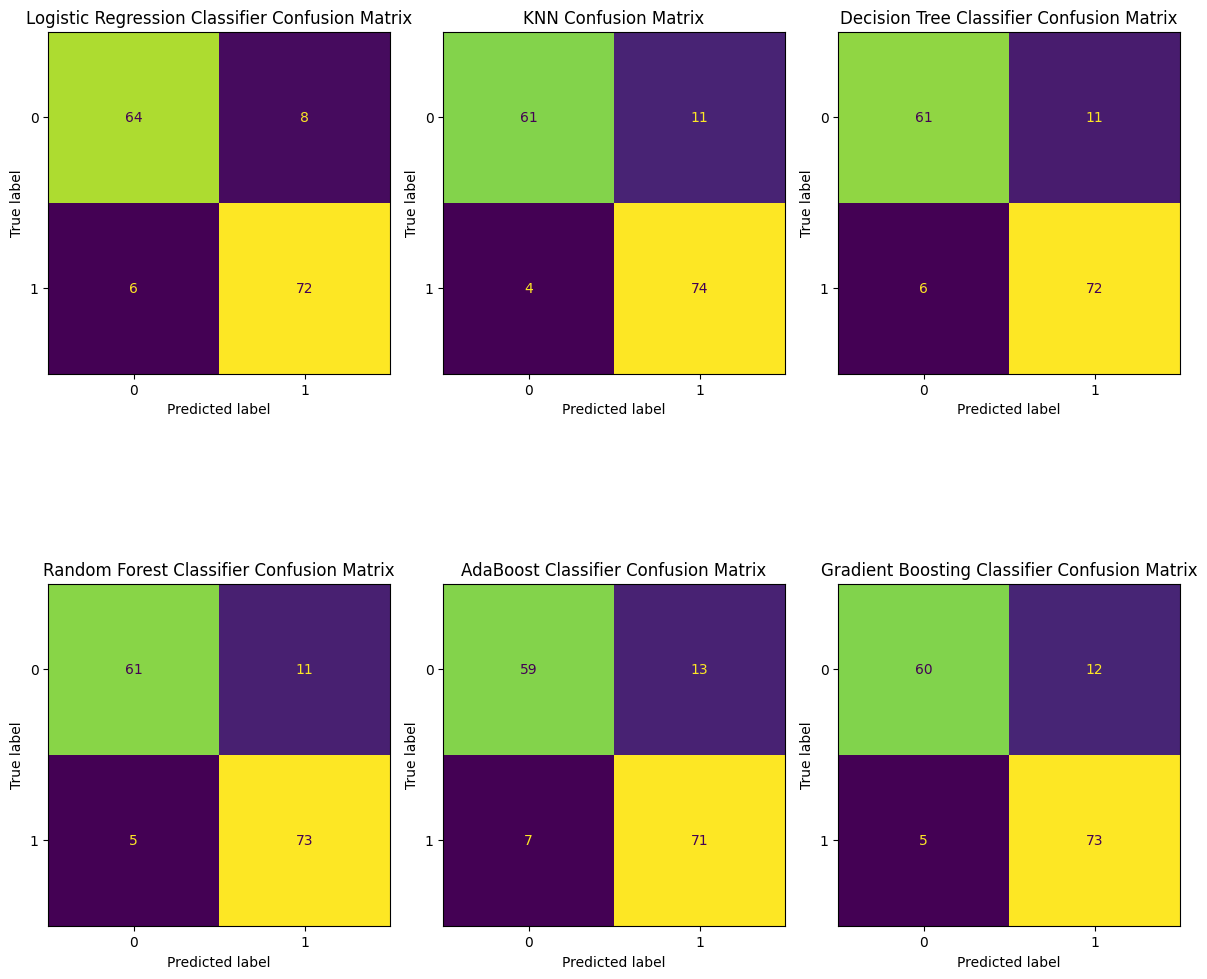

In [ ]:
# Create subplots: 3 rows x 2 columns
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 12))
axes = axes.flatten()

# Loop through models, generate predictions once, and plot
for i, (model, name) in enumerate(model_list):
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        predictions[i],
        ax=axes[i],
        colorbar=False)
    axes[i].set_title(f"{name} Confusion Matrix")

plt.tight_layout()
plt.show()

In [ ]:
report_rows = [] # Store results here

for model, name in model_list:
    y_pred = model.predict(scaled_X_test)
    report_dict = classification_report(y_test, y_pred, output_dict=True)

    metrics = report_dict["1"]  # Collecting metrics for class 1 (heart disease)

    report_rows.append({
        "Model": name,
        "Precision": metrics["precision"],
        "Recall": metrics["recall"],
        "F1-Score": metrics["f1-score"],
        "Support": metrics["support"]
    })

# Convert to DataFrame
df_report = pd.DataFrame(report_rows)

In [ ]:
df_report.sort_values('Recall', ascending=False)

,Model,Precision,Recall,F1-Score,Support
1,KNN,0.870588,0.948718,0.907975,78.0
3,Random Forest Classifier,0.869048,0.935897,0.901235,78.0
5,Gradient Boosting Classifier,0.858824,0.935897,0.895706,78.0
0,Logistic Regression Classifier,0.900000,0.923077,0.911392,78.0
2,Decision Tree Classifier,0.867470,0.923077,0.894410,78.0
4,AdaBoost Classifier,0.845238,0.910256,0.876543,78.0


## Conclusion

All six models demonstrate high recall, ranging from 0.91 to 0.95, which is excellent given our domain goal of minimizing false negatives (i.e., not missing patients at risk of heart failure).

KNN achieved the highest recall at 0.9487, slightly edging out others, and paired it with a strong F1-score (0.908), suggesting it's effective at catching positive cases without sacrificing too much precision.

Logistic Regression had the highest precision at 0.90, with a strong balance overall (F1-score = 0.911).

Random Forest and Gradient Boosting classifiers both showed strong balance, with F1-scores above 0.89 and recall near or above 0.93, highlighting their value for structured, tabular data.

AdaBoost trailed slightly in precision and F1-score, but still maintained a solid recall of 0.91. This model may benefit from hyperparameter tuning or deeper base learners.